In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
# from torchsummary import summary

# from pushover import notify
# from utils import makegif
from random import randint

from IPython.display import Image
from IPython.core.display import Image, display

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
# import torch.nn.functional as F
# import torchvision.transforms.functional as F

from file_manipulations import getSortedFramePaths

from vae_conv import VariationalAutoencoder, Encoder, Decoder
from vae_lstm import LSTM

from images2video import Images2Video

In [2]:
device = torch.device("cuda")

In [3]:
vae = VariationalAutoencoder().to(device)
vae.load_state_dict(torch.load('vae_conv.pth'))
vae.eval()

VariationalAutoencoder(
  (encoder): Encoder(
    (conv_1): Conv2d(1, 2, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv_2): Conv2d(2, 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv_3): Conv2d(4, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv_4): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc_mu): Linear(in_features=1024, out_features=784, bias=True)
    (fc_logvar): Linear(in_features=1024, out_features=784, bias=True)
  )
  (decoder): Decoder(
    (conv_trans_1): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv_trans_2): ConvTranspose2d(8, 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv_trans_3): ConvTranspose2d(4, 2, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv_trans_4): ConvTranspose2d(2, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (linear): Lin

In [4]:
vae_lstm = LSTM().to(device)
vae_lstm.load_state_dict(torch.load('vae_lstm.pth'))
vae_lstm.eval()

LSTM(
  (l_lstm): LSTM(784, 1024, batch_first=True)
  (l_linear): Linear(in_features=3072, out_features=784, bias=True)
  (sigmoid): Sigmoid()
)

In [5]:
image_path = "/media/hitsuji/Back/Dance Data/Skeleton/Advanced/"
image_names = getSortedFramePaths(image_path, ['gLH'])

In [23]:
idx, seq_len = 0, 3

In [24]:
# encoder take the first parameter mu

In [25]:
composed_transform = torchvision.transforms.Compose([transforms.Resize(128), transforms.Grayscale(num_output_channels=1), transforms.ToTensor()])
start_image_locations = image_names[idx:idx+seq_len]
images_x = torch.empty(seq_len, 1, 128, 128)
i = 0

with torch.no_grad():
    for image_location in start_image_locations:
        x = (composed_transform(Image.open(image_location)) > 0.5).float().view(1, 1, 128, 128)
        images_x[i] = x
        i += 1

In [26]:
images_x.shape

torch.Size([3, 1, 128, 128])

In [27]:
#     = vae.decoder(vae.encoder((composed_transform(Image.open(start_image_locations[0])) > 0.5).float().view(1, 1, 128, 128).to(device))[0])

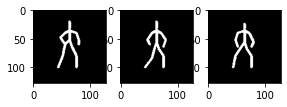

In [28]:
for i in range(3):
    plt.subplot(1, 4, i+1)
    plt.imshow(images_x[i].view(128, 128), cmap="gray")

In [29]:
start_frames = images_x.to(device)

In [30]:
pointer = 0
batch_size = 1
with torch.no_grad():
    while pointer < 600:
        vae_lstm.init_hidden(batch_size)
        
        current_window = start_frames[pointer:pointer+seq_len+1]
        encoded_window = vae.encoder(current_window)[0]
        encoded_window = torch.unsqueeze(encoded_window, 0)
#         print(start_frames.shape)
        
#         current_window = torch.unsqueeze(current_window, 0)
        y_latent = vae_lstm(encoded_window)
        
#         start_frames = torch.cat((start_frames, y_latent), dim=0)

        y_frame_decoded = vae.decoder(y_latent)
        start_frames = torch.cat((start_frames, y_frame_decoded), dim=0)
        
        pointer += 1

In [31]:
start_frames.shape

torch.Size([603, 1, 128, 128])

In [32]:
# plt.imshow(y_pred_decoded[0].cpu().view(128, 128), cmap="gray")

In [33]:
# new_tensor = torch.cat((start_frames, torch.unsqueeze(y_latent, 0)), dim=1)

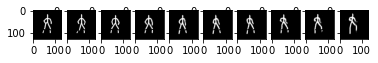

In [34]:
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(start_frames[i].cpu().view(128, 128), cmap="gray")

In [35]:
import torchvision.transforms.functional as F

In [36]:
i = 0
while i < start_frames.shape[0]-1:
    predicted_images = start_frames.cpu()
    image = predicted_images[i]
    image = F.to_pil_image(image)
    image.save(f'generated/vae_lstm/predicted_{i}.png')
    i += 1

In [37]:
Images2Video('generated/vae_lstm/', 'generated/vae_lstm/output.avi', (128, 128))